### Sample the posterior $P(\theta|X)$ from `SEDflow` dataproduct. Don't do this on GPU!

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import pickle
import corner
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.table import Table

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
import popsed
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)

In [4]:
f = h5py.File('./nsa_sedflow/nsa.sedflow.v0.2.hdf5', 'r')

In [5]:
# print data columns
print(f.keys())

<KeysViewHDF5 ['NSAID', 'beta1', 'beta2', 'beta3', 'beta4', 'fburst', 'log_gamma1', 'log_gamma2', 'log_mstar', 'log_sfr_1gyr', 'log_z_mw', 'mag_g', 'mag_i', 'mag_r', 'mag_u', 'mag_z', 'n_dust', 'redshift', 'sedflow', 'sigma_g', 'sigma_i', 'sigma_r', 'sigma_u', 'sigma_z', 'tau_bc', 'tau_ism', 'tburst']>


In [5]:
# read data
logm = f['log_mstar'][...]
beta1 = f['beta1'][...]
beta2 = f['beta2'][...]
beta3 = f['beta3'][...]
beta4 = f['beta4'][...]
fburst = f['fburst'][...]
tburst = f['tburst'][...]
logzsol = f['log_z_mw'][...]
dust1 = f['tau_bc'][...]
dust2 = f['tau_ism'][...]
dust_index = f['n_dust'][...]

redshift = f['redshift'][...]
redshift = np.repeat(redshift[:, None], logm.shape[1], axis=1)

In [15]:
ind = np.random.randint(0, 10000, size=(12))

In [18]:
data = np.vstack([beta1[:, ind].ravel(), 
                  beta2[:, ind].ravel(), 
                  beta3[:, ind].ravel(), 
                  beta4[:, ind].ravel(), 
                  fburst[:, ind].ravel(), 
                  tburst[:, ind].ravel(), 
                  logzsol[:, ind].ravel(), 
                  dust1[:, ind].ravel(), 
                  dust2[:, ind].ravel(), 
                  dust_index[:, ind].ravel(), 
                  redshift[:, ind].ravel(),
                  logm[:, ind].ravel()]).T

In [96]:
np.save('./nsa_sedflow/params_posterior.npy', data)

In [19]:
labels = ['beta1\\_sfh', 
          'beta2\\_sfh',
          'beta3\\_sfh',
          'beta4\\_sfh',
 'fburst',
 'tburst',
 'logzsol',
 'dust1',
 'dust2',
 'dust\\_index',
 'redshift',
 'logm']

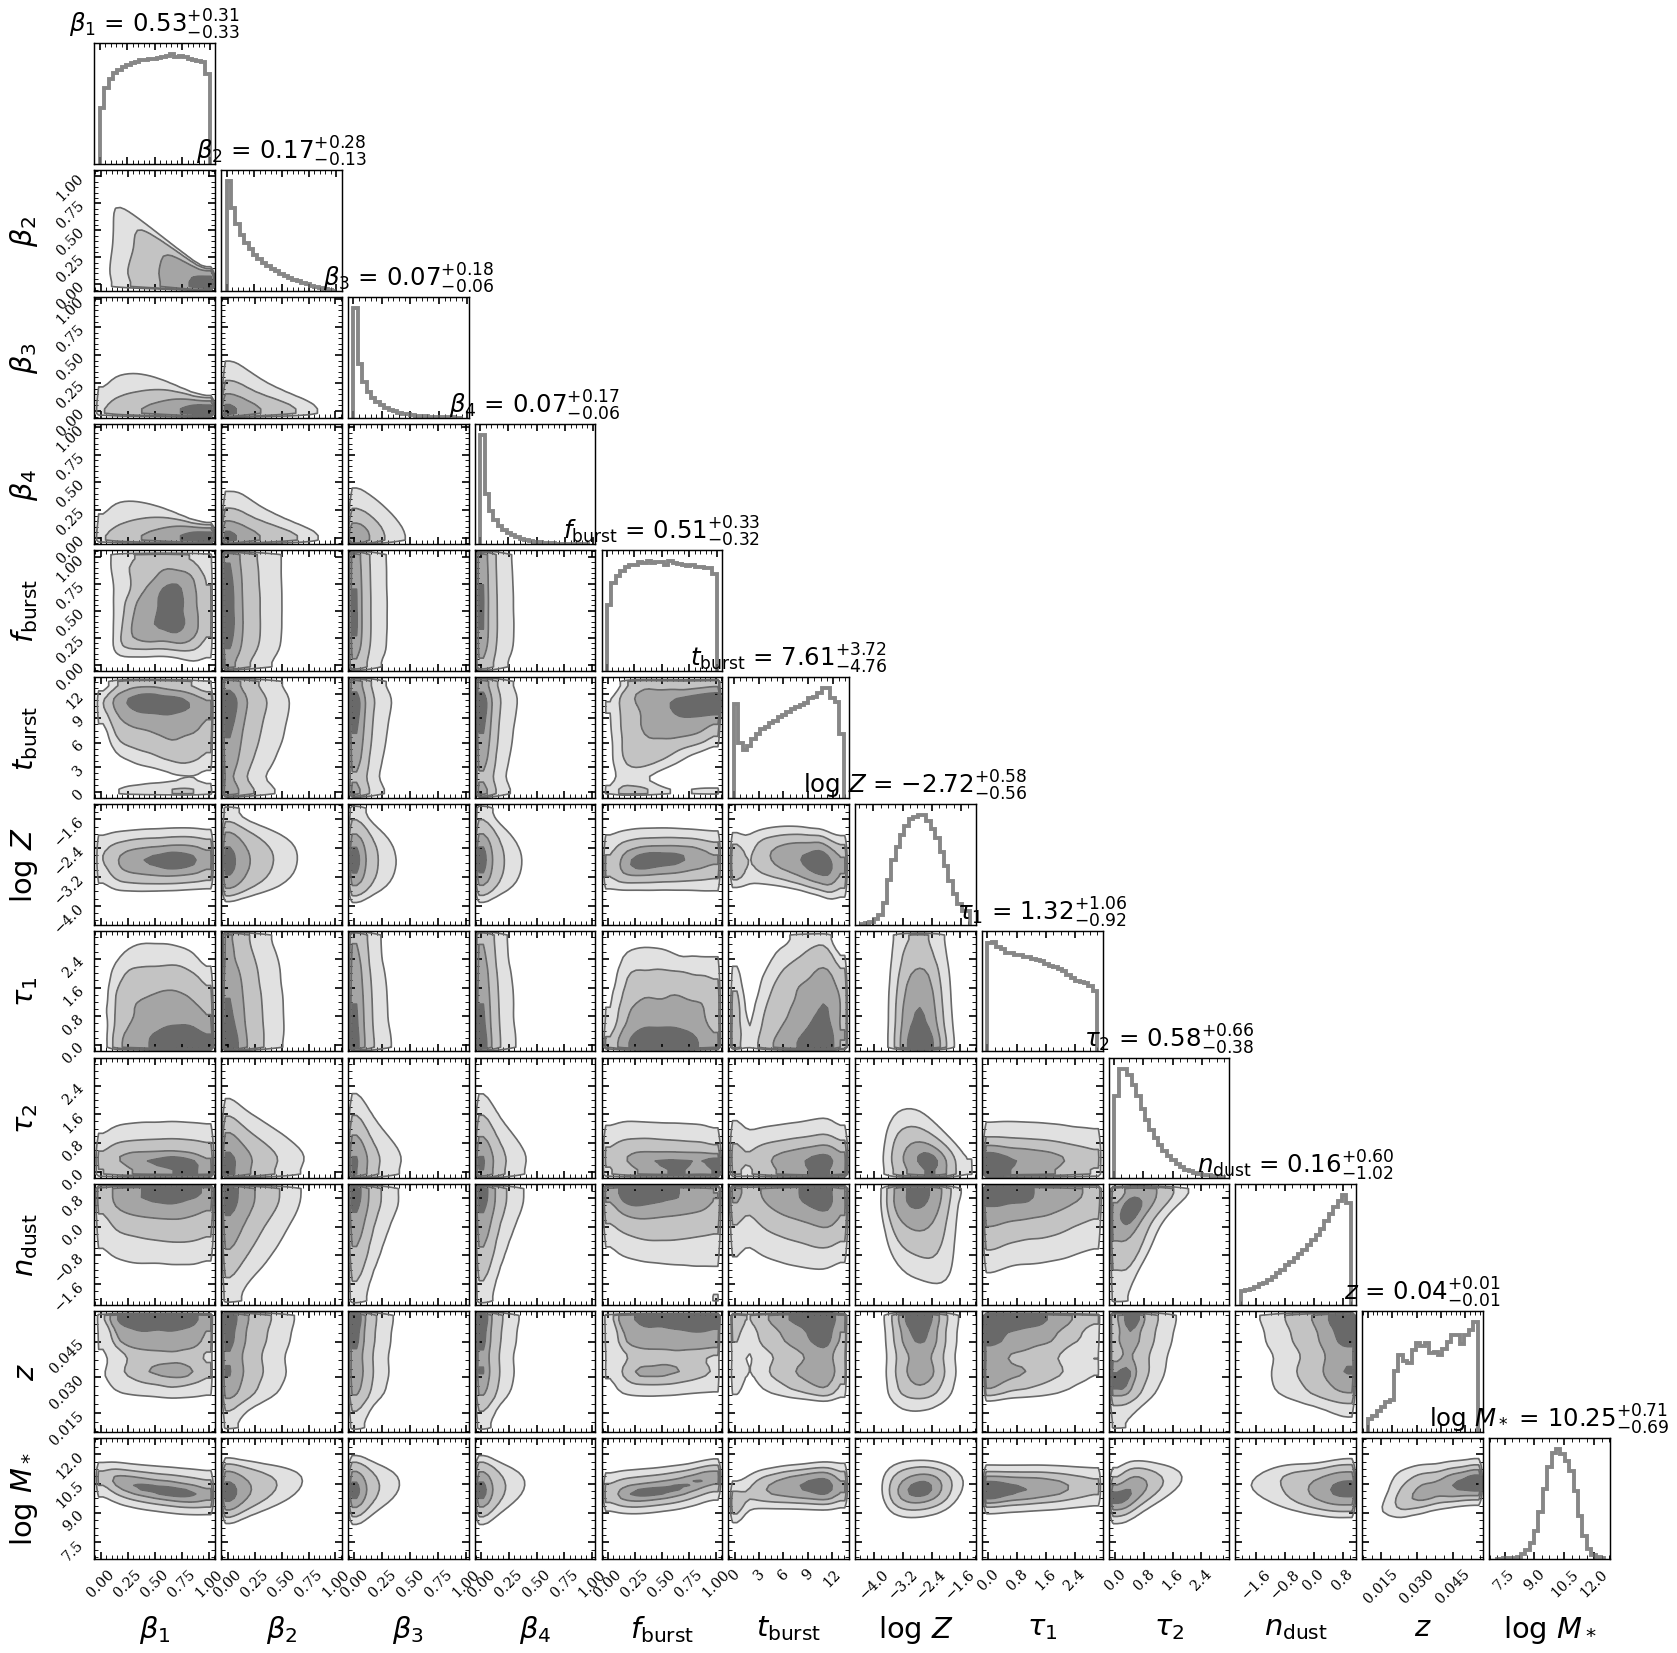

In [63]:
import matplotlib.lines as mlines

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    data,
    fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [43]:
ids = f['NSAID'][...]

In [ ]:
# nsa_cat = Table.read('./reference_catalog/nsa_v1_0_1.fits')
nsa_cat = Table.read('./reference_catalog/nsa_v0_1_2.fits')
# try to match nsa_cat with Chang's selection
# flag = np.in1d(nsa_cat['NSAID'].data, ids)
# nsa_cat = nsa_cat[flag]
# nsa_cat[flag].write('./reference_catalog/nsa_cleaned.fits')

In [47]:
nsa_cat['NSAID'].data

array([     0,      3,      4, ..., 125881, 125910, 125923], dtype=int32)

In [62]:
redshift.max()

0.05499971

In [50]:
nsa_cat[nsa_cat['NSAID'] == 3]

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,ZLG,ZDIST,ZDIST_ERR,NSAID,NMGY [7],NMGY_IVAR [7],OK,RNMGY [7],ABSMAG [7],AMIVAR [7],EXTINCTION [7],KCORRECT [7],KCOEFF [5],MTOL [7],B300,B1000,METS,MASS,XCEN,YCEN,NPROF [7],"PROFMEAN [15,7]","PROFMEAN_IVAR [15,7]","QSTOKES [15,7]","USTOKES [15,7]","BASTOKES [15,7]","PHISTOKES [15,7]",PETROFLUX [7],PETROFLUX_IVAR [7],FIBERFLUX [7],FIBERFLUX_IVAR [7],BA50,PHI50,BA90,PHI90,SERSICFLUX [7],SERSICFLUX_IVAR [7],SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY [7],CLUMPY [7],DFLAGS [7],AID,PID,DVERSION,PROFTHETA [15],PETROTHETA,PETROTH50,PETROTH90,SERSIC_TH50,OBJNO,PLATE,FIBERID,MJD,COEFF [7],VDISP,D4000,D4000ERR,FA,FAERR,S2FLUX,S2FLUXERR,S2EW,S2EWERR,S2VMEAS,S2VMERR,S2RATIO,HAFLUX,HAFLUXERR,HAEW,HAEWERR,HAVMEAS,HAVMERR,N2FLUX,N2FLUXERR,N2EW,N2EWERR,N2VMEAS,N2VMERR,HBFLUX,HBFLUXERR,HBEW,HBEWERR,HBVMEAS,HBVMERR,O1FLUX,O1FLUXERR,O1EW,O1EWERR,O1VMEAS,O1VMERR,O2FLUX,O2FLUXERR,O2EW,O2EWERR,O2VMEAS,O2VMERR,O3FLUX,O3FLUXERR,O3EW,O3EWERR,O3VMEAS,O3VMERR,AHGEW,AHGEWERR,AHDEW,AHDEWERR,NE3EW,NE3EWERR,NE5EW,NE5EWERR,AV,S2NSAMP,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC
bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,float32,float32,float32,int32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,bytes8,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,bytes6,bytes23,bytes8,int32,float64,float64
J094919.08+000144.0,09h/p00/J094919.08+000144.0,147.32950521628283,0.028894913633412792,3,72785,-1,-1,56985,-1,16.134386,0.04808582,sdss,0.07,1239,4,180,301,324.5332,842.7559,0.04747421,0.04747421,0.0005003469,3,21.155905 .. 1113.3317,0.603878 .. 0.0010015934,1,21.69276 .. 1140.3468,-16.630169 .. -20.986282,229.27872 .. 1053.154,0.58096266 .. 0.10364822,-0.026963672 .. 0.026164318,3.045989e-05 .. 1.7737104e-06,0.00010708464 .. 1.0530488,0.006719279,0.15671675,0.027916402,17028572000.0,171.45782470703125,144.43565368652344,0.19710416 .. 9.331073,0.19710416 .. 0.0,481.45764 .. 0.0,-0.0032465244 .. -0.020936118,-0.0007019025 .. -0.1323591,0.993379 .. 0.7636611,-83.900185 .. -49.494194,11.808323 .. 977.8289,3.2221653 .. 0.0038644318,0.6246256 .. 213.05737,145.38692 .. 0.28115124,0.7694611,56.61258,0.72054744,53.483795,12.389294 .. 1049.9419,2.781058 .. 0.021590417,2.1455417,0.55806905,54.0206,0.0093895495 .. -0.027051687,0.19180746 .. 0.051007494,0 .. 0,0,29,v2_1_5,0.22341923 .. 258.39,8.891541,3.5870962,9.522999,4.291172,26603630,266,36,51630,0.84390074 .. 0.0032970388,104.319695,1.4494456,0.01946383,0.16839138,0.021531805,186.90607,8.893222,4.2627735,0.30276892,88.95603,3.686098,0.89916414,651.2687,9.368165,14.864705,0.36004284,89.68645,2.4228513,480.08133,8.495414,10.957486,0.2665358,95.312485,2.9588237,95.76799,9.061308,2.4238408,0.18502863,47.259506,5.0152965,17.348866,6.043424,0.4027296,0.17348716,47.835415,23.182861,194.42235,16.21693,9.814399,1.3268546,57.227352,8.390934,93.56589,8.352453,2.4302778,0.28153995,103.92744,10.063097,2.1748774,0.5545349,-1.9929916,0.58134633,0.6900291,0.7406984,-9999.0,-9999.0,2.5573373,24.391052,147.32950057685355,0.028901991727888092,

In [6]:
mag_data = np.vstack([f[f'mag_{filt}'][...] for filt in 'ugriz'])

In [7]:
np.save('./nsa_sedflow/nsa_mag_data.npy', mag_data)

In [14]:
sigma_mag_data = np.vstack([f[f'sigma_{filt}'][...] for filt in 'ugriz'])

In [15]:
np.save('./nsa_sedflow/nsa_mag_err_data.npy', sigma_mag_data)

In [18]:
np.save('./nsa_sedflow/nsa_redshift.npy', f['redshift'][...])

### Quality cuts based on NSA

In [43]:
nsa_cat = Table.read('./reference_catalog/nsa_v1_0_1.fits')
# try to match nsa_cat with Chang's selection
# flag = np.in1d(nsa_cat['NSAID'].data, ids)
# nsa_cat = nsa_cat[flag]
# nsa_cat[flag].write('./reference_catalog/nsa_cleaned.fits')

In [44]:
flag = ~np.any(nsa_cat['DFLAGS'].data, axis=1)
nsa_cat = nsa_cat[flag]

In [49]:
from popsed.utils import flux2mag
mag_data = flux2mag(nsa_cat['ELPETRO_FLUX'].data).data[:, 2:] # ugriz 01234

In [57]:
flag = ((mag_data[:, 0] - mag_data[:, 1]) > 0)
flag &= ((mag_data[:, 1] - mag_data[:, 2]) > 0)
flag &= ((mag_data[:, 1] - mag_data[:, 4]) > 0)
flag &= ((mag_data[:, 2] - mag_data[:, 3]) > 0)
flag &= ((mag_data[:, 2] - mag_data[:, 4]) > 0)

In [58]:
mag_data = mag_data[flag]

In [59]:
mag_data.shape

(365544, 5)

In [ ]:
u-g > 0

g-z > 0

r-i > 0

r-z > 0

In [83]:
ind = np.random.choice(range(len(nsa_cat)), size=(30000), replace=False)

In [73]:
np.save('./reference_catalog/nsa_v101_redshift.npy', nsa_cat['ZDIST'].data)

In [93]:
mag_data = flux2mag(nsa_cat[ind]['ELPETRO_FLUX'].data).data
np.save('./reference_catalog/nsa_v101_mag_data.npy', mag_data)

In [78]:
np.save('./reference_catalog/nsa_v101_logm.npy', np.log10(nsa_cat['ELPETRO_MASS'].data).data)

(array([8.800e+01, 1.120e+02, 1.670e+02, 1.980e+02, 2.720e+02, 4.150e+02,
        4.820e+02, 6.280e+02, 7.640e+02, 9.080e+02, 1.100e+03, 1.335e+03,
        1.689e+03, 2.030e+03, 2.464e+03, 2.813e+03, 3.054e+03, 3.348e+03,
        2.875e+03, 2.242e+03, 1.415e+03, 7.360e+02, 3.210e+02, 1.440e+02,
        5.300e+01, 3.100e+01, 6.000e+00, 4.000e+00, 4.000e+00, 1.000e+00]),
 array([ 8.      ,  8.133333,  8.266666,  8.4     ,  8.533334,  8.666667,
         8.8     ,  8.933333,  9.066667,  9.2     ,  9.333333,  9.466666,
         9.6     ,  9.733334,  9.866667, 10.      , 10.133333, 10.266666,
        10.4     , 10.533334, 10.666667, 10.8     , 10.933333, 11.066667,
        11.2     , 11.333333, 11.466666, 11.6     , 11.733334, 11.866667,
        12.      ], dtype=float32),
 <BarContainer object of 30 artists>)

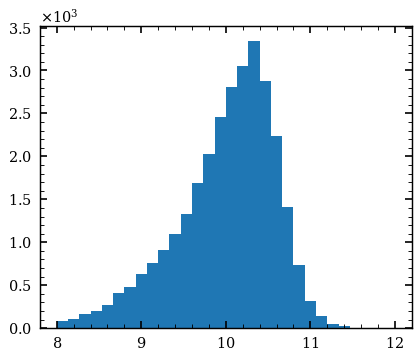

In [87]:
plt.hist(np.log10(nsa_cat[ind]['ELPETRO_MASS']), range=(8, 12), bins=30)

(array([  71.,  228.,  228.,  406.,  656.,  858.,  982.,  897.,  970.,
        1070., 1089., 1050., 1253., 1294., 1390., 1592., 1661., 1423.,
        1220., 1162., 1145., 1217., 1159., 1122., 1014., 1026., 1111.,
         994.,  876.,  836.]),
 array([-0.00186129,  0.00320025,  0.00826178,  0.01332332,  0.01838486,
         0.02344639,  0.02850793,  0.03356947,  0.03863101,  0.04369254,
         0.04875408,  0.05381562,  0.05887716,  0.06393869,  0.06900023,
         0.07406177,  0.0791233 ,  0.08418484,  0.08924638,  0.09430791,
         0.09936945,  0.10443099,  0.10949253,  0.11455406,  0.1196156 ,
         0.12467714,  0.12973867,  0.13480021,  0.13986175,  0.14492328,
         0.14998482], dtype=float32),
 <BarContainer object of 30 artists>)

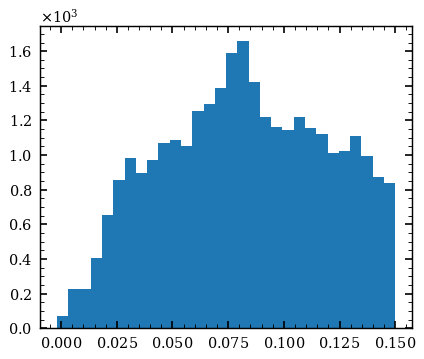

In [88]:
plt.hist(nsa_cat[ind]['Z'], bins=30)

In [79]:
### compare NSA colors with training colors
# nsa_mags = np.load('./reference_catalog/nsa_v101_mag_data.npy')[:, 2:]
train_mags = np.load('./train_sed_NMF/training_mags.npy')

In [80]:
color_combs = list(combinations(range(len(channels)), 2))

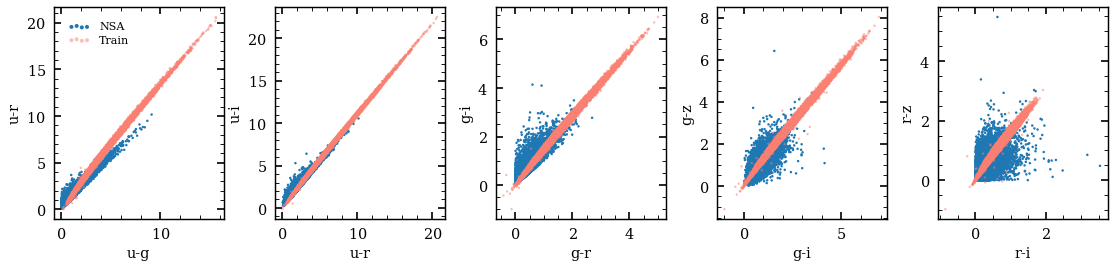

In [82]:
from itertools import combinations
channels = 'ugriz'

fig, axes = plt.subplots(1, 5, figsize=(17, 3.5))

for i, (filt1, filt2) in enumerate(zip([0, 0, 1, 1, 2], [1, 2, 2, 3, 3])):
    plt.sca(axes[i]) 
#     filt2 = filt1 + 1
    _temp = mag_data
    plt.scatter(_temp[:, filt1] - _temp[:, filt2], 
                _temp[:, filt1] - _temp[:, filt2 + 1],
                s=5, edgecolors='none', label='NSA')
    
    _temp = train_mags
    plt.scatter(_temp[:, filt1] - _temp[:, filt2], 
                _temp[:, filt1] - _temp[:, filt2 + 1],
                s=5, edgecolors='none', 
                color='salmon', label='Train', 
                alpha=0.5)
    plt.xlabel(channels[filt1] + '-' + channels[filt2])
    plt.ylabel(channels[filt1] + '-' + channels[filt2 + 1])
    
    if i == 0:
        lgnd = plt.legend(scatterpoints=4, fontsize=10)
        for handle in lgnd.legendHandles:
            handle.set_sizes([13.0])
    
plt.subplots_adjust(wspace=0.3)

In [69]:
import corner

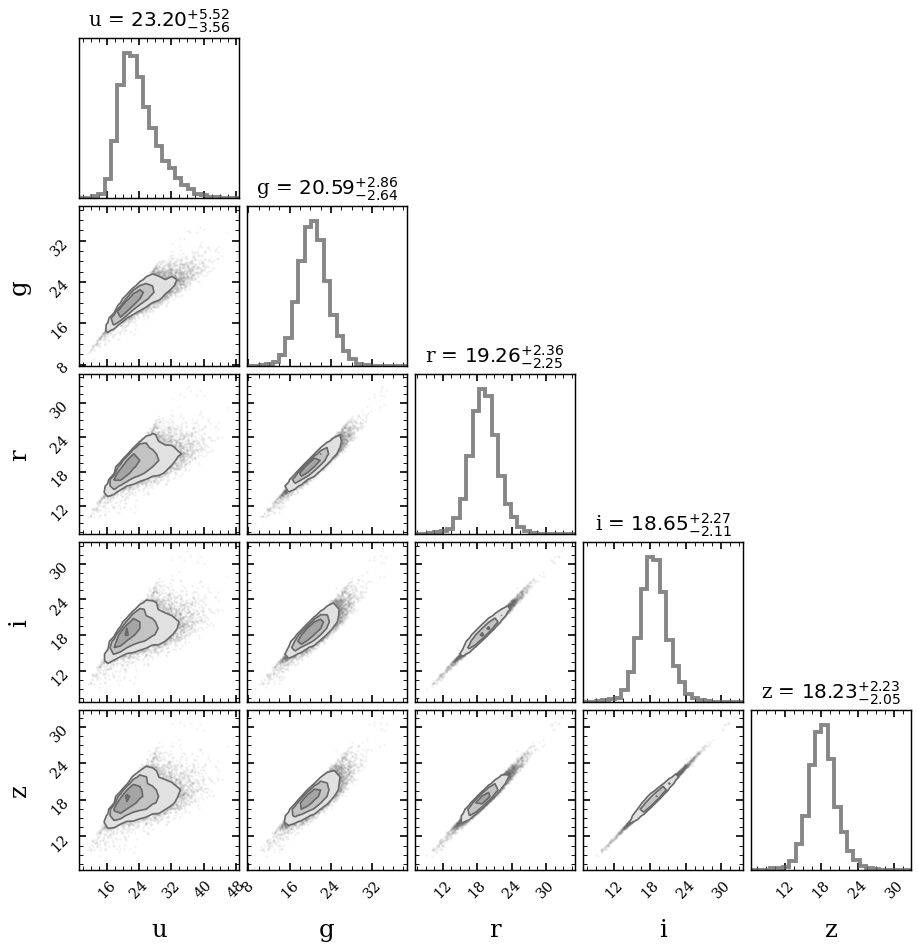

In [81]:
figure = corner.corner(
    train_mags,
    color='dimgray',
    labels=list('ugriz'),
    bins=25,
    smooth=.1,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 22},
    hist_kwargs={'density': True},
    plot_datapoints=True
    )

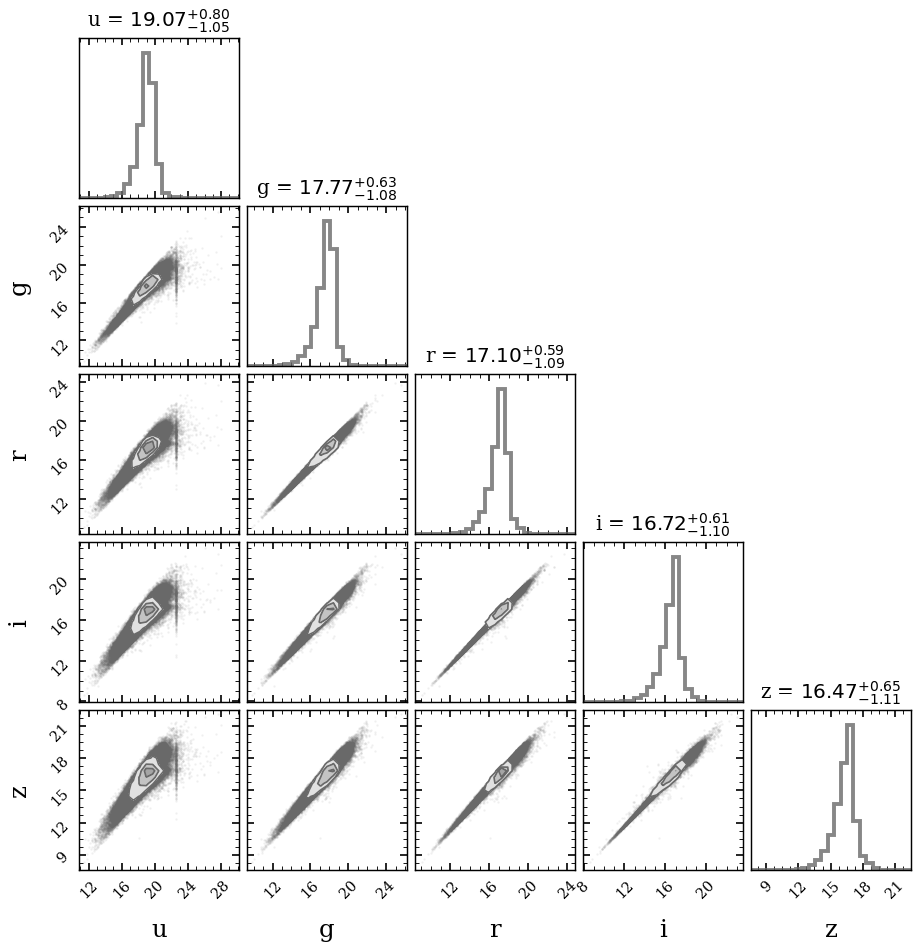

In [64]:
figure = corner.corner(
    mag_data,
    color='dimgray',
    labels=list('ugriz'),
    bins=25,
    smooth=.1,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 22},
    hist_kwargs={'density': True},
    plot_datapoints=True
    )